In [2]:

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
#random generator seed experiment can be replicated identically on any machine
torch.manual_seed(111)
     

In [8]:
#creating a device object that points either to the CPU or, if one is available, to the GPU:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
#function to be used when loading the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
#load the training data using torchvision.datasets.MNIST
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

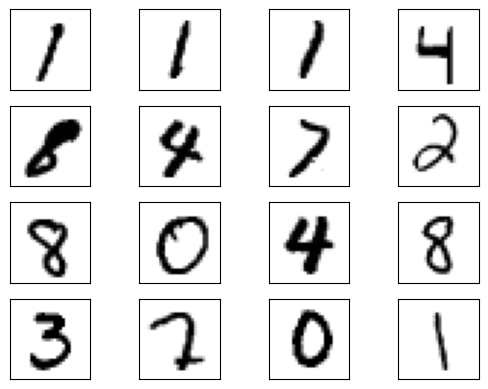

In [9]:
#create train_set
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

#samples of the training data
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    #converts the shape of the input tensor
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [14]:
#Training Loop

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5423752069473267
Epoch: 0 Loss G.: 0.5297333002090454
Epoch: 1 Loss D.: 0.0569315068423748
Epoch: 1 Loss G.: 5.598962306976318
Epoch: 2 Loss D.: 0.01272020023316145
Epoch: 2 Loss G.: 6.753225326538086
Epoch: 3 Loss D.: 0.01833321899175644
Epoch: 3 Loss G.: 5.312521457672119
Epoch: 4 Loss D.: 0.10992677509784698
Epoch: 4 Loss G.: 4.583713531494141
Epoch: 5 Loss D.: 0.1070781722664833
Epoch: 5 Loss G.: 5.9324235916137695
Epoch: 6 Loss D.: 0.09288644045591354
Epoch: 6 Loss G.: 6.526761531829834
Epoch: 7 Loss D.: 0.047265518456697464
Epoch: 7 Loss G.: 3.228353500366211
Epoch: 8 Loss D.: 0.19809883832931519
Epoch: 8 Loss G.: 2.1709303855895996
Epoch: 9 Loss D.: 0.2533726692199707
Epoch: 9 Loss G.: 2.611970901489258


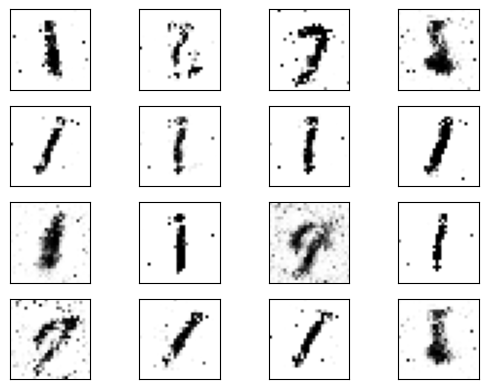

In [16]:

latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
     